In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import altair as alt
from keras.engine.saving import load_model
import pickle
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
def predict_with_mode(model, X_holdout, mode):
    if mode == 'regular':
        pred = model.predict(X_holdout)
    if mode == 'lr':
        pred = model.predict(np.fliplr(X_holdout))
        pred = np.fliplr(pred)
    if mode == 'ud':
        pred = model.predict(X_holdout*(-1))
        pred = pred

    return pred


k=0
mode='regular'
input_file_name = f'/home/geoanton/Repos/gamma_log_classification/data/processed/{mode}_train_nn_0.pck'
#input_file_name = f'/home/anton/Repos/gamma_log_classification/data/interim/regular_train_nn_0.pck'

with open(input_file_name, 'rb') as f:
        results = pickle.load(f)

X, y = results[f'data_dict_train_{k}']['X_with_fake'], results[f'data_dict_train_{k}']['y_with_fake']
X = np.pad(X, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')
y = np.pad(y, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')

X_holdout, y_holdout = results[f'data_dict_test_{k}']['X'], results[f'data_dict_test_{k}']['y']
X_holdout = np.pad(X_holdout, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')
y_holdout = np.pad(y_holdout, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')

model = load_model(f'/home/geoanton/Repos/gamma_log_classification/models/unet_fold_0.hdf5')


Using TensorFlow backend.
/home/geoanton/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geoanton/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geoanton/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/geoanton/an


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [3]:
pred = predict_with_mode(model,X_holdout,mode)


In [4]:
def prepare_df(pred,X,y):
    wells = np.arange(X.shape[0])
    list_df_wells = [pd.DataFrame({'GR':X[w,2:(X.shape[1] - 2)].flatten(),'row_id':np.arange(X.shape[1]-4),'well_id':w}) for w in wells]
    for df in list_df_wells:
        df.index = np.arange(df.shape[0])

    for i, df_well in enumerate(list_df_wells):
        df_well['pred'] = np.argmax(pred[i, :], axis=1)[2:(pred.shape[1] - 2)]
        df_well['label'] = np.argmax(y[i, :], axis=1)[2:(pred.shape[1] - 2)]
        for j in range(5):
            df_well[f'pred_proba_{j}'] = pred[i, 2:(pred.shape[1] - 2),j]
        
    result = pd.concat(list_df_wells, axis=0)
    return result


def stretch_well(s, y, scale=1.1):
    knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')

    if scale >= 1:
        n_new = scale * s.shape[0]
        s_new = resample(s, int(n_new))
        y_new = resample(y, int(n_new))
        confident_samples = np.ceil(y_new) == np.round(y_new)
        # Get KNN on confident samples
        x_axis = np.arange(s_new.shape[0])
        X = x_axis[confident_samples].reshape(-1, 1)
        y = np.abs(np.ceil(y_new[confident_samples]))
        knn.fit(X, y)
        y_new = knn.predict(x_axis.reshape(-1, 1))
        result_x = s_new
        result_y = y_new
        result_y[result_y > 4] = 4
        result_y[result_y < 0] = 0
    else:
        raise ValueError
    return result_x, result_y


def get_stretch_well(x, scale=2):
    X_train, y_train = x[0],x[1]

    if len(X_train.shape) == 2:
        X_train = np.expand_dims(X_train, axis=0)
        y_train = np.expand_dims(y_train,axis=0)
    n_wells = X_train.shape[0]
    new_length = scale * X_train.shape[1]
    y_new = np.zeros((y_train.shape[0], new_length, y_train.shape[2]))
    X_new = np.zeros((X_train.shape[0], new_length, X_train.shape[2]))

    for i in range(n_wells):
        for j in range(X_train.shape[2]):
            s = X_train[i, :, j]
            labels_well = np.argmax(y_train[i, :, :], axis=1)
            s_new, label = stretch_well(s, labels_well, scale=scale)

            X_new[i, :, j] = s_new
            y_new[i, :, :] = to_ohe(label.astype(int))

    return X_new, y_new


def get_stretch_well_parallel(X_train, y_train, scale=2):
    n_wells = X_train.shape[0]
    print(f'Dealing with {n_wells}')
    new_length = scale * X_train.shape[1]
    print(f'New length {new_length}')

    y_new = np.zeros((y_train.shape[0], new_length, y_train.shape[2]))
    X_new = np.zeros((X_train.shape[0], new_length, X_train.shape[2]))

    list_wells = [(X_train[i, :, :],y_train[i,:,:]) for i in range(X_train.shape[0])]

    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(executor.map(get_stretch_well, list_wells), total=len(list_wells)))
    X_new = np.concatenate([r[0] for r in results],axis=0)
    y_new = np.concatenate([r[1] for r in results], axis=0)

    return X_new, y_new


df_train= prepare_df(pred,X_holdout,y_holdout)

In [7]:
#df_train.to_csv('pred_regular_fold_0.csv',index=False)
scores =[]
wells_low_score = []
for w in np.arange(X_holdout.shape[0]):
    df_sub = df_train[df_train['well_id'] == w].copy()
    #df_sub.loc[df_sub['GR'] < (-0.9),'label'] = 2
    sc = accuracy_score(df_sub['label'],df_sub['pred'])
    scores.append(sc)
    if sc < 0.97:
        #print(f'Accuracy {sc} for w = {w}')
        wells_low_score.append(w)
#print(np.mean(scores))


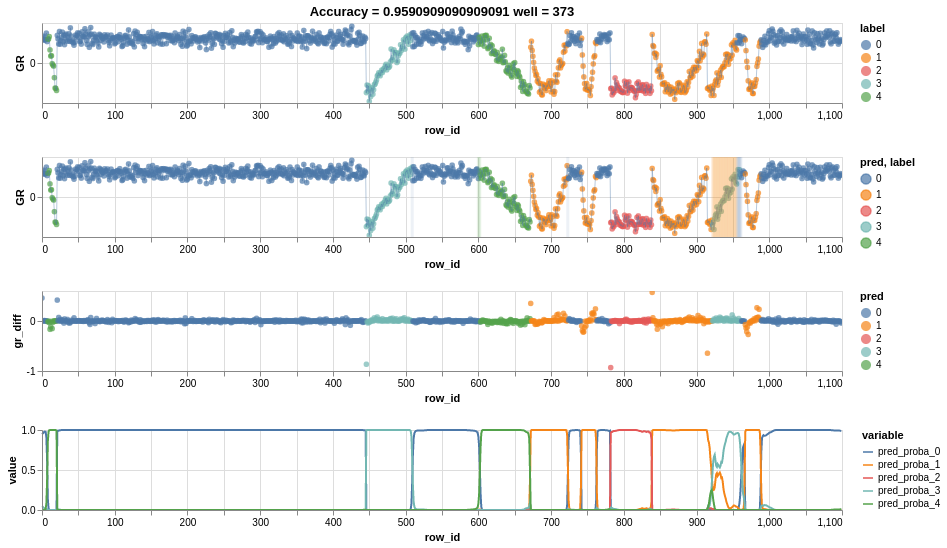

In [24]:
from sklearn.metrics import accuracy_score
from scipy.signal import medfilt
#well_ids = 80
#well_ids = 64
#well_ids = 80
well_ids  = np.random.choice(wells_low_score,1)[0]
#well_ids = 47
#well_ids = 647




df_sub = df_train[df_train['well_id'] == well_ids].copy()
#df_sub['gr_diff'] = medfilt(df_sub['GR'],3) - df_sub['GR']
df_sub['gr_diff'] = np.diff(medfilt(df_sub['GR'],11),prepend=0)

cols = ['GR','row_id','well_id','label','pred','gr_diff']
sc = accuracy_score(df_sub['label'],df_sub['pred'])
title= f'Accuracy = {sc} well = {well_ids}'
df_sub_rules = df_sub[df_sub['label'] !=  df_sub['pred']]

ch_rules = alt.Chart(df_sub_rules[['row_id','label']],height=80,width=800).encode(x='row_id',color='label:N').mark_rule(size=3,opacity=0.1)
ch_gr = alt.Chart(df_sub[cols],height=80,width=800,title=title).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
#ch_lab = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_grp = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR',order='row_id',color='pred:N').mark_point(size=30,filled=True)
ch_grp_l = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR',order='row_id').mark_line(size=0.4)
ch_grp_diff = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='gr_diff',order='row_id',color='pred:N').mark_point(size=30,filled=True)
df_probs = df_sub[[f'pred_proba_{j}' for j in range(5)]+['row_id']].melt(id_vars='row_id').reset_index()
ch_probs = alt.Chart(df_probs,height=80,width=800).encode(x='row_id',y='value',order='row_id',color='variable').mark_line()




ch_block = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y=alt.Y('GR',scale=alt.Scale(type='log')),order='row_id',color='label:N').mark_point(size=30,filled=True).interactive()

((ch_gr + ch_grp_l ).interactive() & (ch_grp+ch_grp_l+ch_rules).interactive() & ch_grp_diff.interactive() & ch_probs ).resolve_scale(color='independent',y='independent')


In [ ]:
scores =[]
for w in np.arange(X_holdout.shape[0]):
    df_sub = df_train[df_train['well_id'] == w].copy()
    #df_sub.loc[df_sub['GR'] < (-0.9),'label'] = 2
    sc = accuracy_score(df_sub['label'],df_sub['pred'])
    scores.append(sc)
    if sc < 0.945:
        print(f'Accuracy {sc} for w = {w}')
print(np.mean(scores))

# Check test submission

In [ ]:
df_test = pd.read_csv('../data/processed/submit_nn_ud.csv')
df_test_GR = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')
df_test_regular = pd.read_csv('../data/processed/submit_nn_regular.csv')


In [ ]:
#=200
well_ids = df_test['well_id'].sample(10).values[5]
df_sub = df_test[df_test['well_id'] == well_ids]
df_sub['GR'] = df_test_GR[df_test_GR['well_id'] == well_ids]['GR']
#df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)

ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line


In [ ]:
#=200
df_sub = df_test_regular[df_test_regular['well_id'] == well_ids]
df_sub['GR'] = df_test_GR[df_test_GR['well_id'] == well_ids]['GR']
#df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)

ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line


In [ ]:
import os
import pickle
with open(os.path.join('..', "data", "interim","test_dict"),'rb') as f:
    X_test,pred_test = pickle.load(f)
h=150
i=19
df_tmp = pd.DataFrame({'GR':X_test[i,:].flatten(),'label':np.argmax(pred_test[i,:], axis=1),'row_id':np.arange(X_test.shape[1])})
ch_gr = alt.Chart(df_tmp,height=h,width=700).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_tmp,height=h,width=700).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_line = alt.Chart(df_tmp,height=h,width=700).encode(x='row_id',y='GR',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line

In [ ]:
df_test


In [ ]:
df_label_lags = calculate_lags(s=X['pred_proba_0'], note=f'pred_proba_0', lags=np.arange(-50, 50, 5))
df_label_lags

In [ ]:
(df_test['label'] == df_test_regular['label']).mean()